# ルートを評価するために解くLPについて
- ルートが1つ与えられた後、そのルートを評価するためにLPを解く(ルートが実行可能であるとは限らない)

<!--- 各制約の違反度を変数とし、それらに重みをかけて足し合わせた関数の最小化問題とする-->
- 車両が各顧客へ到着する時刻を変数とし、その合計を最小化する問題とする
- 制約は、容量制約と時間枠制約とする
    - 容量制約は、ある区間における2つの関数の積分値(面積)の大小を比較するという形で表す(車両の積荷の量を表す区分線形関数の\[x0, xn\]までの積分値と最大容量を表す線形関数の\[x0, xn\]までの積分値)
    - 時間枠制約は、通常のVRPの定式化と同様に表す


# LPへ入力する値の処理

## 問題例の読み込み
使用した問題例 : https://neo.lcc.uma.es/vrp/vrp-instances/description-for-files-of-solomons-instances/

In [105]:
class Customer():
    def __init__(self, x, y, d, e, l, s):
        self.x = x
        self.y = y
        self.d = d
        self.e = e
        self.l = l
        self.s = s

In [106]:
import glob

files = glob.glob("./solomon_25/*")
for file in files:
    print(file)

./solomon_25/R101.txt
./solomon_25/R103.txt
./solomon_25/R102.txt
./solomon_25/R112.txt
./solomon_25/R106.txt
./solomon_25/R107.txt
./solomon_25/R105.txt
./solomon_25/R111.txt
./solomon_25/C108.txt
./solomon_25/RC208.txt
./solomon_25/C109.txt
./solomon_25/R110.txt
./solomon_25/R104.txt
./solomon_25/R201.txt
./solomon_25/R202.txt
./solomon_25/R203.txt
./solomon_25/R207.txt
./solomon_25/R206.txt
./solomon_25/R210.txt
./solomon_25/R204.txt
./solomon_25/C208.txt
./solomon_25/R205.txt
./solomon_25/R211.txt
./solomon_25/RC108.txt
./solomon_25/RC105.txt
./solomon_25/R208.txt
./solomon_25/C205.txt
./solomon_25/C204.txt
./solomon_25/R209.txt
./solomon_25/RC104.txt
./solomon_25/RC106.txt
./solomon_25/C206.txt
./solomon_25/C207.txt
./solomon_25/RC107.txt
./solomon_25/RC103.txt
./solomon_25/C203.txt
./solomon_25/C202.txt
./solomon_25/RC102.txt
./solomon_25/C201.txt
./solomon_25/RC101.txt
./solomon_25/R109.txt
./solomon_25/C104.txt
./solomon_25/RC204.txt
./solomon_25/RC205.txt
./solomon_25/C105.txt

In [107]:
# 問題例の選択
file = files[0]

In [108]:
C_dict = {}
with open(file, mode="r") as f:
    for index,line in enumerate(f):
        #print(line)
        l = []
        if index==4:
            line_s = [s.strip("\n") for s in line.split("\t")][0]
            for s in line_s.split(" "):
                if s!="":
                    l.append(int(s))
            K, Q = l
        elif 9<=index<=34:
            line_s = [s.strip("\n") for s in line.split("\t")][0]
            for s in line_s.split(" "):
                if s!="":
                    l.append(int(s))
            C_dict[l[0]] = Customer(*l[1:])

In [109]:
print("\t", list(vars(C_dict[0]).keys()))
for i in C_dict.keys():
    print(i, end="\t")
    for key, val in vars(C_dict[i]).items():
        print(val, end=" ")
    print()

	 ['x', 'y', 'd', 'e', 'l', 's']
0	35 35 0 0 230 0 
1	41 49 10 161 171 10 
2	35 17 7 50 60 10 
3	55 45 13 116 126 10 
4	55 20 19 149 159 10 
5	15 30 26 34 44 10 
6	25 30 3 99 109 10 
7	20 50 5 81 91 10 
8	10 43 9 95 105 10 
9	55 60 16 97 107 10 
10	30 60 16 124 134 10 
11	20 65 12 67 77 10 
12	50 35 19 63 73 10 
13	30 25 23 159 169 10 
14	15 10 20 32 42 10 
15	30 5 8 61 71 10 
16	10 20 19 75 85 10 
17	5 30 2 157 167 10 
18	20 40 12 87 97 10 
19	15 60 17 76 86 10 
20	45 65 9 126 136 10 
21	45 20 11 62 72 10 
22	45 10 18 97 107 10 
23	55 5 29 68 78 10 
24	65 35 3 153 163 10 
25	65 20 6 172 182 10 


## ルートの作成

In [158]:
# 入力
## 顧客
C={} # 客の座標を保存する辞書
TW={} # 客の時間枠を保存する辞書
demand={} # 客の要求量(正の値は集荷，負の値は配達)
S={} # 客のサービス時間

for i in C_dict:
    x, y = C_dict[i].x, C_dict[i].y
    C[i] = (x,y)
    e, l = C_dict[i].e, C_dict[i].l
    TW[i] = (e,l)
    demand[i] = (C_dict[i].d, )
    S[i] = C_dict[i].s
    """name="c"+str(i)
    x, y = C_dict[i].x, C_dict[i].y
    C[name] = (x,y)
    e, l = C_dict[i].e, C_dict[i].l
    TW[name] = (e,l)
    demand[name] = (C_dict[i].d, )
    S[name] = C_dict[i].s"""
C["depot"]=(0,0)

## 車両
M = K//2 # number of vehicles
capacities = [(Q*2, ) for k in range(M)] # capacity of vehicle

In [159]:
print("Customer",C)
print("Time Window",TW)
print("Demand",demand)
print("Service Time",S)

Customer {0: (35, 35), 1: (41, 49), 2: (35, 17), 3: (55, 45), 4: (55, 20), 5: (15, 30), 6: (25, 30), 7: (20, 50), 8: (10, 43), 9: (55, 60), 10: (30, 60), 11: (20, 65), 12: (50, 35), 13: (30, 25), 14: (15, 10), 15: (30, 5), 16: (10, 20), 17: (5, 30), 18: (20, 40), 19: (15, 60), 20: (45, 65), 21: (45, 20), 22: (45, 10), 23: (55, 5), 24: (65, 35), 25: (65, 20), 'depot': (0, 0)}
Time Window {0: (0, 230), 1: (161, 171), 2: (50, 60), 3: (116, 126), 4: (149, 159), 5: (34, 44), 6: (99, 109), 7: (81, 91), 8: (95, 105), 9: (97, 107), 10: (124, 134), 11: (67, 77), 12: (63, 73), 13: (159, 169), 14: (32, 42), 15: (61, 71), 16: (75, 85), 17: (157, 167), 18: (87, 97), 19: (76, 86), 20: (126, 136), 21: (62, 72), 22: (97, 107), 23: (68, 78), 24: (153, 163), 25: (172, 182)}
Demand {0: (0,), 1: (10,), 2: (7,), 3: (13,), 4: (19,), 5: (26,), 6: (3,), 7: (5,), 8: (9,), 9: (16,), 10: (16,), 11: (12,), 12: (19,), 13: (23,), 14: (20,), 15: (8,), 16: (19,), 17: (2,), 18: (12,), 19: (17,), 20: (9,), 21: (11,), 2

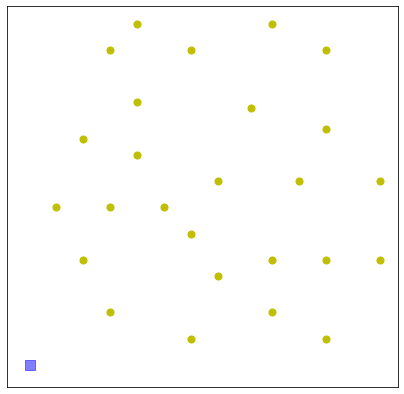

In [160]:
import networkx as nx
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(7,7))

G=nx.DiGraph()
nx.draw_networkx(G,pos=C,nodelist=[i for i in C if i != "depot"],node_color="y",node_size=50,with_labels=True,edge_color="k",width=1)
nx.draw_networkx(G,pos=C,nodelist=["depot"],node_color="blue",node_shape='s',alpha=0.5,node_size=100,with_labels=True,edge_color="k",width=1)

plt.show()

In [161]:
# 距離関数の定義
#def Distance(t1,t2):
#    return ((t1[0]-t2[0])**2+(t1[1]-t2[1])**2)**(0.5)
def distance(x1, y1, x2, y2):
    return ((x2-x1)**2+(y2-y1)**2)**(0.5)

# ソルバーの読み込み
import sys
sys.path.append('..')

#from vrplib.vrp_d_1m1_t_model import *
import vrplib.vrp_d_1m1_t_model as vrp

# ソルバーの実行
model = vrp.Model(file.split("/")[-1].split(".")[0]) # モデルインスタンスの生成

## 客インスタンスの生成
for i in C:
    if i == "depot":
        continue
    model += vrp.Customer(i,demand=demand[i],timewindow=TW[i],servicetime=S[i])

## 車両インスタンスの生成
for k in range(M):
    model += vrp.Vehicle("v"+str(k),capacity=capacities[k])
    
## 枝インスタンスの生成
for i in C:
    for j in C:
        if i!=j:
            dist = time = Distance(C[i],C[j])
            model += vrp.Edge(i,j,dist,time)

In [162]:
## 最適化の実行
obj=model.optimize(IterLimit=100,TimeLimit=1,Verbose=False,OutputFlag=False)

## 得られた解の表示
print("objective value =",obj)
for v in model.vehiclesL:
    print()
    print(v)
    print(list(map(lambda x:x.name,v.routing[1:-1])))    
    for iv in map(lambda x:x.name,v.routing[1:-1]):
        print(iv)

objective value = 1211.62

Vehicle v0: {'capacity': (400,)}
173.07639 = {'distance': 173.07639, 'freight_1M1': 0.0, 'timecost': 0.0}
[0, 9, 20, 1]
0
9
20
1

Vehicle v1: {'capacity': (400,)}
36.055513 = {'distance': 36.055513, 'freight_1M1': 0.0, 'timecost': 0.0}
[14]
14

Vehicle v2: {'capacity': (400,)}
117.873959 = {'distance': 117.873959, 'freight_1M1': 0.0, 'timecost': 0.0}
[2, 21, 4]
2
21
4

Vehicle v3: {'capacity': (400,)}
67.082039 = {'distance': 67.082039, 'freight_1M1': 0.0, 'timecost': 0.0}
[5]
5

Vehicle v4: {'capacity': (400,)}
60.827625 = {'distance': 60.827625, 'freight_1M1': 0.0, 'timecost': 0.0}
[17]
17

Vehicle v5: {'capacity': (400,)}
164.129669 = {'distance': 164.129669, 'freight_1M1': 0.0, 'timecost': 0.0}
[11, 19, 10, 13]
11
19
10
13

Vehicle v6: {'capacity': (400,)}
169.362606 = {'distance': 169.362606, 'freight_1M1': 0.0, 'timecost': 0.0}
[12, 3, 24, 25]
12
3
24
25

Vehicle v7: {'capacity': (400,)}
112.504867 = {'distance': 112.504867, 'freight_1M1': 0.0, 'timecos

## ルートを1つ選ぶ

In [215]:
tour = [12, 3, 24, 25]+["depot"]

# 全体を1つのLPとして解くver.
1. ルートが与えられる
1. Primalを解く

In [229]:
import gurobipy as gp

# インスタンスの生成
m = gp.Model("LP_for_VRP_small")

# 定数を設定


# 変数を設定
"""
x_i : 顧客iへ車両が到着する時刻を表す変数
"""
x = {i:m.addVar(vtype=gp.GRB.CONTINUOUS, name=f"x({i})") for i in tour}

m.update()

In [230]:
# 目的関数を設定
## 各制約の違反度を最小化する
m.setObjective(gp.quicksum(x[i] for i in tour), sense=gp.GRB.MINIMIZE)

In [231]:
C_dict["depot"] = Customer(0,0,0,0,1000,0)

In [232]:
# 制約条件を設定
## 最初に訪問する顧客へ到着する時間の制約
m.addConstr(0<=x[tour[0]])

## ルート内の顧客の順序に関する制約
for index, i in enumerate(tour):
    try:
        i_next = tour[index+1]
    except:
        i_next = "depot"
    m.addConstr(x[i]-x[i_next] <= -distance(C_dict[i].x, C_dict[i].y, C_dict[i_next].x, C_dict[i_next].y))

## 時間枠制約
for i in tour:
    m.addConstr(-x[i] <= -C_dict[i].e)
    m.addConstr(x[i] <= C_dict[i].l)

## 容量制約
integral_val = 0
for index, i in enumerate(tour):
    try:
        i_next = tour[index+1]
    except:
        i_next = "depot"
    integral_val += (x[i_next]-x[i])*gp.quicksum(C_dict[j].d for d in tour[:index+1])
m.addConstr(integral_val <= (x["depot"]-x[tour[0]])*Q*2)

m.update()

In [233]:
import time

# 時間計測スタート
start = time.time()

# 最適化
m.optimize()

# 時間計測ストップ
elapsed_time = time.time() - start
                
# 解の表示
if m.Status == gp.GRB.OPTIMAL:
    for i in tour:
        print(f"車両が顧客{i}に到着する時刻は、{x[i].X}")
        print("最適値 : ", m.ObjVal)
    
print('\033[31m'+f"実時間\t{elapsed_time}"+'\033[0m')

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 17 rows, 5 columns and 21 nonzeros
Model fingerprint: 0x20966c9d
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 17 rows and 5 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.4400735e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  7.440073525e+02
車両が顧客12に到着する時刻は、63.0
最適値 :  744.0073525436771
車両が顧客3に到着する時刻は、116.0
最適値 :  744.0073525436771
車両が顧客24に到着する時刻は、153.0
最適値 :  744.0073525436771
車両が顧客25に到着する時刻は、172.0
最適値 :  744.0073525436771
車両が顧客depotに到着する時刻は、240.0073525436772
最適値 :  744.0073525436771
実時間	0.03548121452331543


# 前半と後半をつなげるver.
1. ルートが与えられる
1. 適当なところで前後に分ける
1. 前半後半それぞれのPrimalを解く
1. 前半と後半それぞれのPrimalの最適解を、全体のDualに入れて解く(つなげる際に必要になる制約A3を考えなければならない)
1. Primalの解を復元